## DFO Nutrient Comparison

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import gsw
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import pickle
import cmocean

mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)
mpl.rc('legend', fontsize=8)
mpl.rc('axes', titlesize=8)
mpl.rc('axes', labelsize=8)
mpl.rc('figure', titlesize=8)
mpl.rc('font', size=8)
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble =r'''
 \usepackage{txfonts}
 \usepackage{lmodern}
 ''')
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

%matplotlib inline

In [2]:
PATH= '/results2/SalishSea/nowcast-green.201905/'
modver='HC1905'
start_date = dt.datetime(2015,1,1)
end_date = dt.datetime(2018,1,1)
flen=1
namfmt='nowcast'
#varmap={'N':'nitrate','Si':'silicon','Ammonium':'ammonium'}
filemap={'nitrate':'ptrc_T','silicon':'ptrc_T','ammonium':'ptrc_T','diatoms':'ptrc_T','ciliates':'ptrc_T','flagellates':'ptrc_T','vosaline':'grid_T','votemper':'grid_T'}
#gridmap={'nitrate':'tmask','silicon':'tmask','ammonium':'tmask'}
fdict={'ptrc_T':1,'grid_T':1}
rematch=False
if rematch==True:
    df1=et.loadDFO()
    df1.head()

In [3]:
if rematch==True:
    data=et.matchData(df1,filemap, fdict, start_date, end_date, namfmt, PATH, flen)
    pickle.dump(data,open(f'/data/eolson/MEOPAR/SS36runs/calcFiles/evalMatches/dataDFO_{start_date}_{end_date}_{modver}.pkl','wb'))
else:
    data=pickle.load(open(f'/data/eolson/MEOPAR/SS36runs/calcFiles/evalMatches/dataDFO_{start_date}_{end_date}_{modver}.pkl','rb'))

In [4]:
def rotmap(lon,lat,lon0,lat0,phi):
    # rotate around point (pick one near center of domain)
    # phi in degrees
    # first scale lats to match and center around lat0,lon0:
    lon1=(lon-lon0)*np.cos(lat0*np.pi/180)
    lat1=lat-lat0
    # now rotate:
    lon2=lon1*np.cos(phi*np.pi/180)-lat1*np.sin(phi*np.pi/180)
    lat2=lon1*np.sin(phi*np.pi/180)+lat1*np.cos(phi*np.pi/180)
    return lon2,lat2

In [5]:
cm1=cmocean.cm.thermal
#plt.get_cmap('PuBuGn')
#cm1=cmo.cm.matter
theta=-30
lon0=-123.9
lat0=49.3
with nc.Dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/bathymetry_201702.nc') as bathy:
    bathylon=np.copy(bathy.variables['nav_lon'][:,:])
    bathylat=np.copy(bathy.variables['nav_lat'][:,:])
    bathyZ=np.copy(bathy.variables['Bathymetry'][:,:])
blon,blat=rotmap(bathylon,bathylat,lon0,lat0,theta)

In [6]:
mod_chl_N=1.6
#mod_chl_N=2.0
data['l10_obsChl']=np.log10(data['Chlorophyll_Extracted']+0.01)
data['l10_modChl']=np.log10(mod_chl_N*(data['mod_diatoms']+data['mod_ciliates']+data['mod_flagellates'])+0.01)
#data['mod_Chl']=mod_chl_N*(data['mod_diatoms']+data['mod_ciliates']+data['mod_flagellates'])

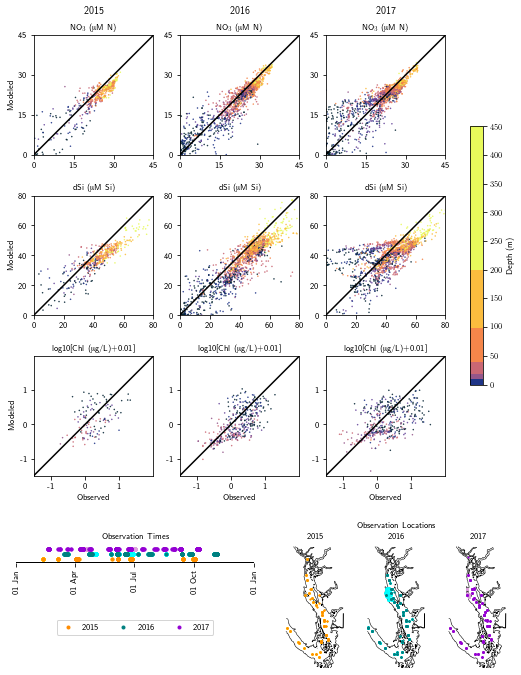

In [12]:
bounds = np.array([0,5,10,15,20,40,100,200,450])
norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=256)
#pcm = ax[1].pcolormesh(X, Y, Z1, norm=norm, cmap='RdBu_r')

fig = plt.figure(figsize = (7.5,9.5))
gsv = gridspec.GridSpec(2,1,left=.08,right=.98,hspace=.2,bottom=.015,top=.94,height_ratios=[3.6,1.1])
gs1=gridspec.GridSpecFromSubplotSpec(3,5,subplot_spec=gsv[0],wspace=.3,hspace=.34,height_ratios=[1,1,1],width_ratios=[1,1,1,.1,.1])
ax2015N=fig.add_subplot(gs1[0,0])
ax2016N = fig.add_subplot(gs1[0,1])
ax2017N = fig.add_subplot(gs1[0,2])
ax2015Si= fig.add_subplot(gs1[1,0])
ax2016Si= fig.add_subplot(gs1[1,1])
ax2017Si= fig.add_subplot(gs1[1,2])
ax2015Chl= fig.add_subplot(gs1[2,0])
ax2016Chl= fig.add_subplot(gs1[2,1])
ax2017Chl= fig.add_subplot(gs1[2,2])
gscb=gridspec.GridSpecFromSubplotSpec(5,1,subplot_spec=gs1[:,3])
axcb = fig.add_subplot(gscb[1:-1])

gsL=gridspec.GridSpecFromSubplotSpec(4,2,hspace=0,subplot_spec=gsv[1],width_ratios=[.9,1.1],height_ratios=[.22,.36,1,1])
#axL2015=fig.add_subplot(gsL[0,0])
axL=fig.add_subplot(gsL[1,0])
#axL2017=fig.add_subplot(gsL[2,0])
gsLmap=gridspec.GridSpecFromSubplotSpec(1,3,wspace=.01,subplot_spec=gsL[1:,1])
axLmap2015=fig.add_subplot(gsLmap[0])
axLmap2016=fig.add_subplot(gsLmap[1])
axLmap2017=fig.add_subplot(gsLmap[2])

for ax in (ax2015N,ax2016N,ax2017N):
    ax.plot((0,45),(0,45),'k-')
for ax in (ax2015Si,ax2016Si,ax2017Si):
    ax.plot((0,80),(0,80),'k-')
for ax in (ax2015Chl,ax2016Chl,ax2017Chl):
    ax.plot((-2,2),(-2,2),'k-')

vm0=-150
args={'marker':'.','s':1,'norm':norm}
data2015=data.loc[(data.dtUTC>=dt.datetime(2015,1,1))&(data.dtUTC<dt.datetime(2016,1,1))]
ps=et.varvarScatter(ax2015N,data2015,'N','mod_nitrate','Z',vmin=vm0,vmax=450,cm=cm1,args=args)

data2016=data.loc[(data.dtUTC>=dt.datetime(2016,1,1))&(data.dtUTC<dt.datetime(2017,1,1))]
ps=et.varvarScatter(ax2016N,data2016,'N','mod_nitrate','Z',vmin=vm0,vmax=450,cm=cm1,args=args)

data2017=data.loc[(data.dtUTC>=dt.datetime(2017,1,1))&(data.dtUTC<dt.datetime(2018,1,1))]
ps=et.varvarScatter(ax2017N,data2017,'N','mod_nitrate','Z',vmin=vm0,vmax=450,cm=cm1,args=args)

ps=et.varvarScatter(ax2015Si,data2015,'Si','mod_silicon','Z',vmin=vm0,vmax=450,cm=cm1,args=args)
ps=et.varvarScatter(ax2016Si,data2016,'Si','mod_silicon','Z',vmin=vm0,vmax=450,cm=cm1,args=args)
ps=et.varvarScatter(ax2017Si,data2017,'Si','mod_silicon','Z',vmin=vm0,vmax=450,cm=cm1,args=args)


ps=et.varvarScatter(ax2015Chl,data2015,'l10_obsChl','l10_modChl','Z',vmin=vm0,vmax=450,cm=cm1,args=args)
ps=et.varvarScatter(ax2016Chl,data2016,'l10_obsChl','l10_modChl','Z',vmin=vm0,vmax=450,cm=cm1,args=args)
ps=et.varvarScatter(ax2017Chl,data2017,'l10_obsChl','l10_modChl','Z',vmin=vm0,vmax=450,cm=cm1,args=args)

cb=fig.colorbar(ps,cax=axcb,boundaries=np.linspace(0,450,46))
cb.set_label('Depth (m)')
#cb.set_ylim(0,450)

ntick=np.arange(0,56,15)
ntickl=[str(i) for i in ntick]
for ax in (ax2015N,ax2016N,ax2017N):
    ax.set_xlim((0,45))
    ax.set_ylim((0,45))
    ax.set_xticks(ntick)
    ax.set_xticklabels(ntickl)
    ax.set_yticks(ntick)
    ax.set_yticklabels(ntickl)
    
stick=np.arange(0,81,20)
stickl=[str(i) for i in stick]
for ax in (ax2015Si,ax2016Si,ax2017Si):
    ax.set_xlim((0,80))
    ax.set_ylim((0,80))
    ax.set_xticks(stick)
    ax.set_xticklabels(stickl)
    ax.set_yticks(stick)
    ax.set_yticklabels(stickl)

ctick=np.arange(-1,2,1)
ctickl=[str(i) for i in ctick]
for ax in (ax2015Chl,ax2016Chl,ax2017Chl):
    ax.set_xlim((-1.5,2))
    ax.set_ylim((-1.5,2))
    ax.set_xticks(ctick)
    ax.set_xticklabels(ctickl)
    ax.set_yticks(ctick)
    ax.set_yticklabels(ctickl)
    
for ax in (ax2015N,ax2016N,ax2017N,ax2015Si,ax2016Si,ax2017Si,ax2015Chl,ax2016Chl,ax2017Chl):
    ax.set_aspect(1, adjustable='box')
    #ax.set_xlabel('Observed')
    
ax2015N.set_ylabel('Modeled')
ax2015Si.set_ylabel('Modeled')
ax2015Chl.set_ylabel('Modeled')
ax2015Chl.set_xlabel('Observed')
ax2016Chl.set_xlabel('Observed')
ax2017Chl.set_xlabel('Observed')

ax2015N.annotate('2015',xy=[.5,1.18],xycoords='axes fraction',ha='center')
ax2016N.annotate('2016',xy=[.5,1.18],xycoords='axes fraction',ha='center')
ax2017N.annotate('2017',xy=[.5,1.18],xycoords='axes fraction',ha='center')
ax2015N.set_title('NO$_3$ ($\muup$M N)')
ax2016N.set_title('NO$_3$ ($\muup$M N)')
ax2017N.set_title('NO$_3$ ($\muup$M N)')
ax2015Si.set_title('dSi ($\muup$M Si)')
ax2016Si.set_title('dSi ($\muup$M Si)')
ax2017Si.set_title('dSi ($\muup$M Si)')
ax2015Chl.set_title('log10[Chl ($\muup$g/L)+0.01]')
ax2016Chl.set_title('log10[Chl ($\muup$g/L)+0.01]')
ax2017Chl.set_title('log10[Chl ($\muup$g/L)+0.01]')

#viz_tools.set_aspect(axLmap)
for axLi in (axLmap2015,axLmap2016,axLmap2017):
    axLi.set_aspect(1, adjustable='box')
    contour_lines = axLi.contour(blon,blat,bathyZ,[1e-5],
                colors='black',zorder=2,linewidths=.5)
    axLi.set_xlim(-1.02,0.81)
    axLi.set_ylim(-1.5,1.8)
    axLi.axis('off')
datanut2015=data2015.loc[(data2015.N>=0)|(data2015.Si>=0)]
datanut2016=data2016.loc[(data2016.N>=0)|(data2016.Si>=0)]
datanut2017=data2017.loc[(data2017.N>=0)|(data2017.Si>=0)]
dataChl2015=data2015.loc[(data2015.Chlorophyll_Extracted>=0)]
dataChl2016=data2016.loc[(data2016.Chlorophyll_Extracted>=0)]
dataChl2017=data2017.loc[(data2017.Chlorophyll_Extracted>=0)]
lons15,lats15=rotmap(datanut2015['Lon'], datanut2015['Lat'],lon0,lat0,theta)
lons16,lats16=rotmap(datanut2016['Lon'], datanut2016['Lat'],lon0,lat0,theta)
lons17,lats17=rotmap(datanut2017['Lon'], datanut2017['Lat'],lon0,lat0,theta)
lons15chl,lats15chl=rotmap(dataChl2015['Lon'], dataChl2015['Lat'],lon0,lat0,theta)
lons16chl,lats16chl=rotmap(dataChl2016['Lon'], dataChl2016['Lat'],lon0,lat0,theta)
lons17chl,lats17chl=rotmap(dataChl2017['Lon'], dataChl2017['Lat'],lon0,lat0,theta)
axLmap2015.plot(lons15,lats15, '.',color='gold',markersize=2)
axLmap2016.plot(lons16,lats16, '.',color='aqua',markersize=2)
axLmap2017.plot(lons17,lats17, '.',color='plum',markersize=2)
axLmap2015.plot(lons15chl,lats15chl, '.',color='darkorange',markersize=2)
axLmap2016.plot(lons16chl,lats16chl, '.',color='teal',markersize=2)
axLmap2017.plot(lons17chl,lats17chl, '.',color='darkviolet',markersize=2)
axLmap2015.set_title('2015',fontsize=8)
axLmap2016.set_title('2016',fontsize=8)
axLmap2017.set_title('2017',fontsize=8)
axLmap2016.annotate('Observation Locations',xy=[.5,1.14],xycoords='axes fraction',ha='center',fontsize=8)

axL.set_title('Observation Times',fontsize=8)
p1a,=axL.plot(datanut2015.dtUTC,np.zeros(np.shape(datanut2015.dtUTC)),'.',color='gold',markersize=6,label='2015')
p2a,=axL.plot(datanut2016.dtUTC-dt.datetime(2016,1,1)+dt.datetime(2015,1,1),np.zeros(np.shape(datanut2016.dtUTC))+.1,'.',color='aqua',markersize=6,label='2016')
p3a,=axL.plot(datanut2017.dtUTC-dt.datetime(2017,1,1)+dt.datetime(2015,1,1),np.zeros(np.shape(datanut2017.dtUTC))+.2,'.',color='plum',markersize=6,label='2017')
p1,=axL.plot(dataChl2015.dtUTC,np.zeros(np.shape(dataChl2015.dtUTC)),'.',color='darkorange',markersize=6,label='2015')
p2,=axL.plot(dataChl2016.dtUTC-dt.datetime(2016,1,1)+dt.datetime(2015,1,1),np.zeros(np.shape(dataChl2016.dtUTC))+.1,'.',color='teal',markersize=6,label='2016')
p3,=axL.plot(dataChl2017.dtUTC-dt.datetime(2017,1,1)+dt.datetime(2015,1,1),np.zeros(np.shape(dataChl2017.dtUTC))+.2,'.',color='darkviolet',markersize=6,label='2017')
axL.set_yticks(());
yearsFmt = mdates.DateFormatter('%d %b')
axL.xaxis.set_major_formatter(yearsFmt)
yy=2015
axL.xaxis.set_ticks([dt.datetime(int(yy),1,1), dt.datetime(int(yy),4,1),dt.datetime(int(yy),7,1),dt.datetime(int(yy),10,1),dt.datetime(int(yy)+1,1,1)])
#labels=axL.xaxis.get_ticklabels()
for tick in axL.get_xticklabels():
        tick.set_rotation(90)
        tick.set_horizontalalignment('center')
axL.set_ylim(-.1,.3)
axLpos=axL.get_position()
new = mpl.transforms.Bbox.from_bounds(0.05,axLpos.bounds[1],0.44,axLpos.bounds[3])
axL.set_position(new)
axL.legend(handles=[p1,p2,p3],loc=8,ncol=3,bbox_to_anchor=[.5,-4])
axL.set_frame_on(False)
#axL.axes.get_yaxis().set_visible(False)
#axL.axes.get_xaxis().set_visible(True)
xmin, xmax = axL.get_xaxis().get_view_interval()
ymin, ymax = axL.get_yaxis().get_view_interval()
axL.add_artist(mpl.lines.Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=2))

fig.savefig(f'/data/eolson/results/MEOPAR/biomodelevalpaper/figsEval/dfoEval{modver}.png',dpi=200,transparent=True)

In [8]:
import importlib
importlib.reload(et)

<module 'salishsea_tools.evaltools' from '/data/eolson/results/MEOPAR/tools/SalishSeaTools/salishsea_tools/evaltools.py'>